Import modules

In [1]:
# Imports - these provided for you. Do not import any other packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import operator

Loading in the data

In [2]:
db_movies = pd.read_csv('./IMDB-Movie-Data.csv') 
db_movies.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [3]:
#Isolate desired variables and eliminate rows with no rating
db_movies = db_movies[['Title','Genre','Rating','Metascore']]
db_movies = db_movies.dropna()

#Add new variables derived from Rating and Metascore
db_movies['Metascore/10'] = db_movies['Metascore']/10
db_movies['Difference'] = db_movies['Rating'] - db_movies['Metascore/10']

In [4]:
print(db_movies.shape)
db_movies.head()

(936, 6)


,Title,Genre,Rating,Metascore,Metascore/10,Difference
0,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",8.1,76.0,7.6,0.5
1,Prometheus,"Adventure,Mystery,Sci-Fi",7.0,65.0,6.5,0.5
2,Split,"Horror,Thriller",7.3,62.0,6.2,1.1
3,Sing,"Animation,Comedy,Family",7.2,59.0,5.9,1.3
4,Suicide Squad,"Action,Adventure,Fantasy",6.2,40.0,4.0,2.2


Identify genres and create dataframes of movies in each genre

In [5]:
#Returns a list of string labels for genres used
def getGenres(dataframe):
    genres = list()
    genreCol = dataframe['Genre']
    
    #Get the entry from the column
    for genreEnt in genreCol:
        #Split and parse strings of genre
        genreEntries = genreEnt.split(',')
        for genre in genreEntries:
            #check if it is in the list
            if not(any(genre in listEntry for listEntry in genres)):
                #Add to list if not included yet
                genres.append(genre)
    return genres

In [6]:
def hasGenre(row,genre):
    return genre in row['Genre']

Bar chart of genre frequency. Movies may be duplicated across genres

In [7]:
#Get the genres used and generate an empty list
genreList = getGenres(db_movies)
genreFreq = list()

#Fill the requency dictionary genreFreq
for genre in genreList:
    freq = 0
    for index, row in db_movies.iterrows():
        if (hasGenre(row,genre)):
            freq += 1
    genreFreq.append((genre,freq))

#Sort dictionary by key into a tuple list
genreFreq.sort(key = lambda tup:tup[1],reverse=True)

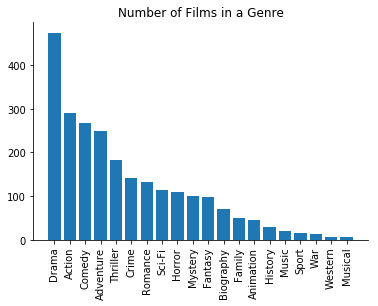

In [8]:
#Plot genreFreq as a bar chart
x = range(len(genreFreq))
x_label, y = zip(*genreFreq)

ax = plt.axes()

plt.bar(x, y, align='center',linewidth=0)
plt.xticks(x,x_label, rotation='vertical')
plt.title('Number of Films in a Genre')
ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
plt.show()



Create new dataframes using the top five genres

In [9]:
def getGenreMovies(movies,genreList):
    movieTables = {}
    for genre in genreList:
        movieTables[genre] = movies.loc[movies['Genre'].str.contains(genre)]
    return movieTables

In [10]:
movieTb = getGenreMovies(db_movies,genreList)

In [11]:
#Get the correlation coefficients between ratings
genreCorr = list()
for genre in genreList:
    genreCorr.append((genre,movieTb[genre].corr()['Rating']['Metascore']))

In [14]:
[tup for tup in genreCorr if abs(tup[1]) > 0.5]

[('Action', 0.7098323955685601),
 ('Adventure', 0.7788994344601379),
 ('Sci-Fi', 0.7330234082371372),
 ('Mystery', 0.6826217121445741),
 ('Thriller', 0.5724756448538111),
 ('Animation', 0.8177319959884246),
 ('Comedy', 0.685347315932671),
 ('Family', 0.7449130031126292),
 ('Fantasy', 0.6293388453567709),
 ('Drama', 0.5517716663823042),
 ('Romance', 0.5827752416847054),
 ('History', 0.6443775688876195),
 ('Crime', 0.597040659772643),
 ('Western', 0.9319643317398625),
 ('War', 0.6266344632309664),
 ('Musical', 0.6869385190597941),
 ('Sport', 0.6112393070167496)]

Plot histogram of differences in rating in movies for each genre

In [29]:
#Merge acion,comedy,and horror films
dumFilms = movieTb['Action'].combine_first(movieTb['Comedy'])
dumFilms = dumFilms.combine_first(movieTb['Horror'])

#Merge drama and historical films
branFilms = movieTb['Drama'].combine_first(movieTb['History'])


dumDiff = dumFilms['Difference']
branDiff = branFilms['Difference']

#Determine if it is normal

st_dum,p_dum = stats.normaltest(dumDiff)
st_bran,p_bran = stats.normaltest(branDiff)

is_n_dum = bool(p_dum > 0.01)
is_n_bran = bool(p_bran > 0.01)

print(stats.ttest_ind(dumDiff,branDiff))
print("Is dumb normal?")
print(is_n_dum)
print("Is smart normal?")
print(is_n_bran)
#Print the t-test on the chart

Ttest_indResult(statistic=4.078583642841564, pvalue=4.868781997324842e-05)
Is dumb normal?
True
Is smart normal?
True


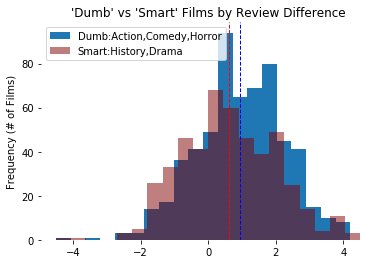

In [30]:




#plt.title('Difference in IMDb User Rating minus Metacritic Rating/10')
#plt.ylabel('Frequency')


#plt.show()
axes1 = dumDiff.hist(bins=20)
axes2 = branDiff.hist(bins=20,fc=(0.5,0,0,0.5))

axes1.set_title("'Dumb' vs 'Smart' Films by Review Difference")
axes1.legend(['Dumb:Action,Comedy,Horror','Smart:History,Drama'])
axes1.set_ylabel("Frequency (# of Films)")

axes1.grid(False)
axes1.set_frame_on(False)

plt.axvline(dumDiff.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(branDiff.mean(), color='red', linestyle='dashed', linewidth=1)


We now perform a one-way ANOVA test on all genres

In [62]:

movieDifferences = list()
movieDifferences_genre = list()

#Get all genre differences
for movieTable in movieTb.items():
    movieDifferences.append(movieTable[1]["Difference"])
    movieDifferences_genre.append(movieTable[0])

assert(len(movieDifferences) == 20)    
    
#Perform the ANOVA test
f_val,p_val = stats.f_oneway(*movieDifferences)

#Print output
print("F Value:")
print(f_val)
print("P Value")
print(p_val)

F Value:
5.378182128927415
P Value
4.504410718071403e-13


In [69]:
#Perform a box plot of the differences
diff_Frame = pd.concat(*movieDifferences)
diff_Frame.head()

TypeError: concat() takes from 1 to 11 positional arguments but 20 were given